In [0]:
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm

import quandl

import warnings
warnings.filterwarnings('ignore')

seed = 10031998

In [0]:
np.random.seed(seed)

In [0]:
def create_lagged_dataset(dataset, lag=1):
    df = pd.DataFrame(dataset)
    for i in range(lag):
        new_feature = df.T.tail(1).T.shift(-1)
        df = pd.concat((df, new_feature), axis=1)
    dataX = df.values[:len(dataset) - lag,:-1]
    dataY = df.values[:len(dataset) - lag,-1]
    return dataX, dataY

In [0]:
# source: https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
# ts_df = quandl.get("FRBP/ROUTPUT_MOSTRECENT", authtoken="MHASo5sqBFCvT5s55CxJ")
ts_df = quandl.get("FRED/DFF", authtoken="MHASo5sqBFCvT5s55CxJ")

In [8]:
ts_df.tail()

,Value
Date,
2019-05-13,2.38
2019-05-14,2.38
2019-05-15,2.40
2019-05-16,2.39
2019-05-17,2.39


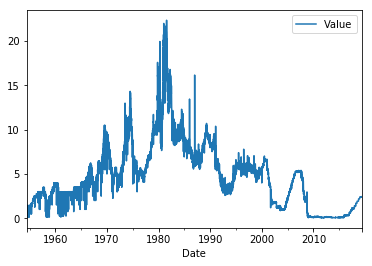

In [9]:
ts_df.plot();

In [0]:
# TOO SLOW !!!


# # for RandomForest
# def validate_gamma(lags, n_splits, ts, gamma_test_part = 6, gammas=[0.3, 0.9, 1]):
#     ts_gamma_train = ts.values[: (gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part)]
#     ts_gamma_test = ts.values[(gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part):]
    
#     res_mape = {}
#     tscv = TimeSeriesSplit(n_splits=n_splits)
#     gammas_best = []
#     i = -1
#     for gamma in gammas:
#         i += 1
#         lowest_mape = 10**10
#         gammas_best.append(-1)
#         for lag in lags:
#             mapes = []
#             for train_index, test_index in tscv.split(ts_gamma_train):
#                 ts_train, ts_test = ts_gamma_train[train_index], ts_gamma_train[test_index]

#                 # train test
#                 X_train, y_train = create_lagged_dataset(ts_train, lag=lag)
#                 X_test, y_test = create_lagged_dataset(ts_test, lag=lag)
#                 model = RandomForestRegressor(random_state=seed)
#                 model.fit(X_train,y_train)
#                 y_hat = model.predict(X_test)

#                 mapes.append(mean_absolute_percentage_error(y_test, y_hat))

            
#             powers = np.arange(len(mapes))[::-1]
#             gammas = np.ones(len(mapes)) * gamma
#             print(np.mean(np.power(gammas, powers) * mapes))
#             res_mape[str(gamma) + "_" + str(lag)] = np.mean(np.power(gammas, powers) * mapes)
#             if np.mean(np.power(gammas, powers) * mapes) < lowest_mape:
#                 gammas_best[i] = lag
#                 lowest_mape = np.mean(np.power(gammas, powers) * mapes)
            
#     mapes_for_gammas = []
#     best_gamma = None
#     if len(np.unique(gammas_best)) == 1:
#         best_gamma = "same_results"
#     else:
#         for gamma_best in gammas_best:
            
#             X_train, y_train = create_lagged_dataset(ts_gamma_train, lag=gamma_best)
#             X_test, y_test = create_lagged_dataset(ts_gamma_test, lag=gamma_best)
#             model = RandomForestRegressor()
#             model.fit(X_train, y_train)
            
#             y_hat = model.predict(X_test)
#             mapes_for_gammas.append(mean_absolute_percentage_error(y_test, y_hat))
        
#         best_gamma = gammas[np.argmin(mapes_for_gammas)]
            
#     return res_mape , gammas_best , best_gamma
            
    
            

In [0]:
# for RandomForest

def validate_gamma(lags, n_splits, ts, gamma_test_part = 6, gammas=[0.1, 0.2, 0.3, 1]):
    ts_gamma_train = ts.values[: (gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part)]
    ts_gamma_test = ts.values[(gamma_test_part - 1) * int(ts.shape[0] // gamma_test_part):]
    
    res_mape = {}
    tscv = TimeSeriesSplit(n_splits=n_splits)
    gammas_best = []
    i = -1

    for lag in lags:
        mapes = []
        for train_index, test_index in tscv.split(ts_gamma_train):
            ts_train, ts_test = ts_gamma_train[train_index], ts_gamma_train[test_index]

            # train test
            X_train, y_train = create_lagged_dataset(ts_train, lag=lag)
            X_test, y_test = create_lagged_dataset(ts_test, lag=lag)
            model = RandomForestRegressor(random_state=seed)
            model.fit(X_train,y_train)
            y_hat = model.predict(X_test)

            mapes.append(mean_absolute_percentage_error(y_test, y_hat))


        for gamma in gammas:
            powers = np.arange(len(mapes))[::-1]
            gammas_pow = np.ones(len(mapes)) * gamma
            res_mape[str(gamma) + "_" + str(lag)] = np.mean(np.power(gammas_pow, powers) * mapes)
            
#     print(res_mape)
    i = -1
    for gamma in gammas:
        i += 1
        lowest_mape = 10**10
        gammas_best.append(-1)
        for lag in lags:
            if res_mape[str(gamma) + "_" + str(lag)] < lowest_mape:
                lowest_mape = res_mape[str(gamma) + "_" + str(lag)]
                gammas_best[i] = lag
            
            
    mapes_for_gammas = []
    best_gamma = None
    if len(np.unique(gammas_best)) == 1:
        best_gamma = "same_results_all_models"
    else:
        for gamma_best in gammas_best:
            X_train, y_train = create_lagged_dataset(ts_gamma_train, lag=gamma_best)
            X_test, y_test = create_lagged_dataset(ts_gamma_test, lag=gamma_best)
            model = RandomForestRegressor()
            model.fit(X_train, y_train)
            
            y_hat = model.predict(X_test)
            mapes_for_gammas.append(mean_absolute_percentage_error(y_test, y_hat))
        
        best_gamma = gammas[np.argmin(mapes_for_gammas)]
    
    if best_gamma != "same_results_all_models":
        if gammas_best[np.argmin(mapes_for_gammas)] == gammas_best[-1]:
            best_gamma = "gamma_1_is_ok"
    return res_mape , gammas_best , best_gamma
            
    
            

In [45]:
validate_gamma([1,2,3], 5, ts_df)

({'0.1_1': 1.2159970057715115,
  '0.1_2': 0.6451695470554688,
  '0.1_3': 0.9346735441938689,
  '0.2_1': 1.3487750037510875,
  '0.2_2': 0.7706716322266821,
  '0.2_3': 1.0455636781545925,
  '0.3_1': 1.5370496132211757,
  '0.3_2': 0.9515319671560608,
  '0.3_3': 1.2166191958150259,
  '1_1': 8.698753112144406,
  '1_2': 8.130199948449285,
  '1_3': 8.663085793698558},
 [2, 2, 2, 2],
 'same_results_all_models')

In [0]:
# M4 competition
df = pd.read_csv("Monthly-train.csv")

In [13]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,...,V2756,V2757,V2758,V2759,V2760,V2761,V2762,V2763,V2764,V2765,V2766,V2767,V2768,V2769,V2770,V2771,V2772,V2773,V2774,V2775,V2776,V2777,V2778,V2779,V2780,V2781,V2782,V2783,V2784,V2785,V2786,V2787,V2788,V2789,V2790,V2791,V2792,V2793,V2794,V2795
0,M1,8000.0,8350.0,8570.0,7700.0,7080.0,6520.0,6070.0,6650.0,6830.0,5710.0,5260.0,5470.0,7870.0,7360.0,8470.0,7880.0,6750.0,6860.0,6220.0,6650.0,5450.0,5280.0,4970.0,5550.0,7750.0,7760.0,7190.0,7440.0,6590.0,6210.0,6010.0,6390.0,5780.0,5700.0,4680.0,4970.0,6850.0,6740.0,7490.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M2,2440.0,2490.0,2710.0,2290.0,1960.0,1990.0,1960.0,2530.0,2640.0,2650.0,2150.0,1910.0,2510.0,2100.0,1840.0,2330.0,1830.0,2290.0,2090.0,2340.0,2420.0,1850.0,1960.0,2000.0,2300.0,2160.0,1730.0,2090.0,1890.0,2180.0,1950.0,2020.0,1770.0,1960.0,1860.0,1340.0,2150.0,2180.0,2030.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M3,2670.0,2590.0,2784.0,2816.0,2888.0,2906.0,2839.0,2860.0,2798.0,2795.0,2796.0,2858.0,2782.0,2801.0,2907.0,2919.0,2937.0,2878.0,2841.0,2967.0,3050.0,2981.0,3076.0,3033.0,2936.0,2927.0,2929.0,2987.0,2777.0,2760.0,2769.0,2830.0,2861.0,2991.0,3063.0,3134.0,3020.0,2947.0,3026.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M4,7264.0,7215.0,7022.0,7040.0,6966.0,6984.0,7025.0,7082.0,6956.0,7014.0,7067.0,7099.0,7046.0,7139.0,7011.0,7022.0,7084.0,7036.0,7098.0,7083.0,7045.0,7057.0,6986.0,6937.0,6927.0,6953.0,7007.0,6949.0,6930.0,6925.0,6956.0,6946.0,6866.0,6814.0,6806.0,6806.0,6855.0,6951.0,6898.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M5,4210.0,4290.0,4250.0,4320.0,4320.0,4330.0,4320.0,4260.0,4220.0,4260.0,4180.0,4230.0,4270.0,4500.0,4410.0,4440.0,4430.0,4440.0,4540.0,4450.0,4420.0,4410.0,4300.0,4300.0,4420.0,4350.0,4340.0,4410.0,4340.0,4400.0,4360.0,4420.0,4470.0,4310.0,4280.0,4220.0,4190.0,4120.0,4150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


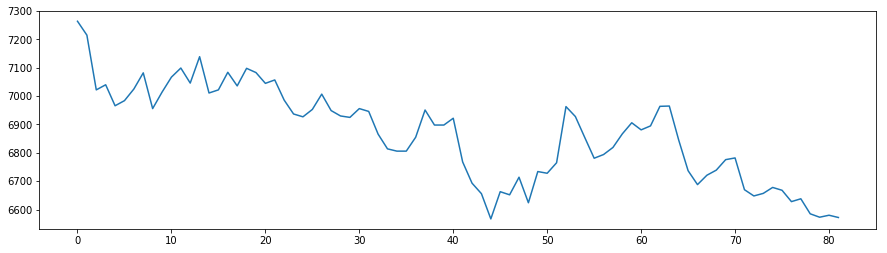

In [46]:
plt.figure(figsize=(15,4))
x = df[3:4].values[0][1:]
x = np.array(x, dtype=float)
x = x[~np.isnan(x)]
plt.plot(x);

In [47]:
validate_gamma(np.arange(1, x.shape[0] // 10, 4), 5, pd.DataFrame(x))

({'0.1_1': 0.16080031635994443,
  '0.1_5': 0.19704529043433658,
  '0.2_1': 0.19680655928946875,
  '0.2_5': 0.24581463685794666,
  '0.3_1': 0.24265246507038238,
  '0.3_5': 0.30883162687676374,
  '1_1': 1.074916412787268,
  '1_5': 1.4722710314384666},
 [1, 1, 1, 1],
 'same_results_all_models')

In [48]:
hist = []
for i in tqdm(np.random.choice(47998, size = 1000)):
    x = df[i:i+1].values[0][1:]
    x = np.array(x, dtype=float)
    x = x[~np.isnan(x)] 
    _, _, best_gamma = validate_gamma(np.arange(1, x.shape[0] // 10, 5), 6, pd.DataFrame(x))
    hist.append(best_gamma)




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 1/1000 [00:00<09:58,  1.67it/s]


  0%|          | 2/1000 [00:01<13:39,  1.22it/s]


  0%|          | 3/1000 [00:02<10:22,  1.60it/s]


  0%|          | 4/1000 [00:02<11:02,  1.50it/s]


  0%|          | 5/1000 [00:03<09:34,  1.73it/s]


  1%|          | 7/1000 [00:05<12:06,  1.37it/s]


  1%|          | 9/1000 [00:05<08:43,  1.89it/s]


  1%|          | 11/1000 [00:06<07:20,  2.25it/s]


  1%|          | 12/1000 [00:06<08:47,  1.87it/s]


  1%|▏         | 13/1000 [00:07<11:44,  1.40it/s]


  1%|▏         | 14/1000 [00:08<09:03,  1.81it/s]


  2%|▏         | 15/1000 [00:10<17:11,  1.05s/it]


  2%|▏         | 16/1000 [00:11<16:36,  1.01s/it]


  2%|▏         | 17/1000 [00:11<15:24,  1.06it/s]


  2%|▏         | 18/1000 [00:12<13:50,  1.18it/s]


  2%|▏         | 20/1000 [00:13<10:40,  1.53it/s]


  2%|▏         | 21/1000 [00:13<10:31,  1.55it/s]


  2%|▏         | 22/1000 [00:14<10:22,  1.57it/s]


  2%|▏         | 23/1000 

In [0]:
unique, counts = np.unique(hist, return_counts = True)

In [0]:
result = list(zip(unique, counts))

In [51]:
result

[('0.1', 85),
 ('0.2', 59),
 ('0.3', 60),
 ('gamma_1_is_ok', 173),
 ('same_results_all_models', 623)]

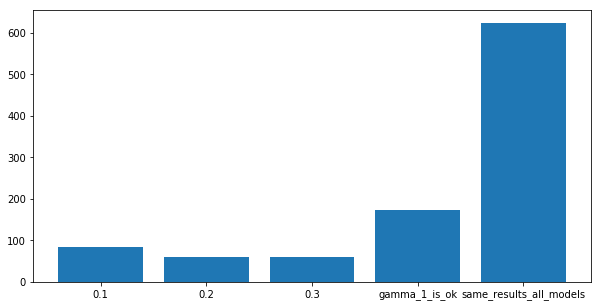

In [52]:
plt.figure(figsize=(10,5))
plt.bar(unique, counts);